In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Anomaly detection and preprocessing for modeling

## Check distribution and outliers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/final_tmdb_with_success.csv'
df = pd.read_csv(file_path)

df.head()

,id,title,revenue,runtime,budget,original_title,release_year,release_month,top_cast_count,top_writers_count,...,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,is_english,spoken_has_english,success
0,5,Four Rooms,4257354.0,98.0,4000000.0,Four Rooms,1995.0,12.0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,6,Judgment Night,12136938.0,109.0,21000000.0,Judgment Night,1993.0,10.0,0,0,...,0,0,0,0,1,0,0,1,1,0
2,12,Finding Nemo,940335536.0,100.0,94000000.0,Finding Nemo,2003.0,5.0,1,0,...,0,0,0,0,0,0,0,1,1,1
3,13,Forrest Gump,677387716.0,142.0,55000000.0,Forrest Gump,1994.0,6.0,1,0,...,0,1,0,0,0,0,0,1,1,1
4,14,American Beauty,356296601.0,122.0,15000000.0,American Beauty,1999.0,9.0,0,0,...,0,0,0,0,0,0,0,1,1,1


                                 count          mean           std  \
budget                          8732.0  2.554006e+07  4.256887e+07   
revenue                         8732.0  7.027646e+07  1.719192e+08   
runtime                         8732.0  1.002337e+02  2.906493e+01   
historical_popularity           8732.0  3.925865e+00  5.274995e-01   
historical_vote_average         8732.0  6.333606e+00  1.174839e-01   
historical_vote_count           8732.0  8.544081e+02  3.934815e+02   
historical_imdb_rating          8732.0  6.598378e+00  1.976926e-01   
historical_imdb_votes           8732.0  5.072140e+04  1.802091e+04   
top_cast_count                  8732.0  2.258360e-01  5.110901e-01   
top_writers_count               8732.0  5.943656e-02  2.766341e-01   
top_director_count              8732.0  4.580852e-02  2.090816e-01   
top_producers_count             8732.0  2.491984e-01  6.083962e-01   
top_production_companies_count  8732.0  5.593220e-01  7.048981e-01   

                   

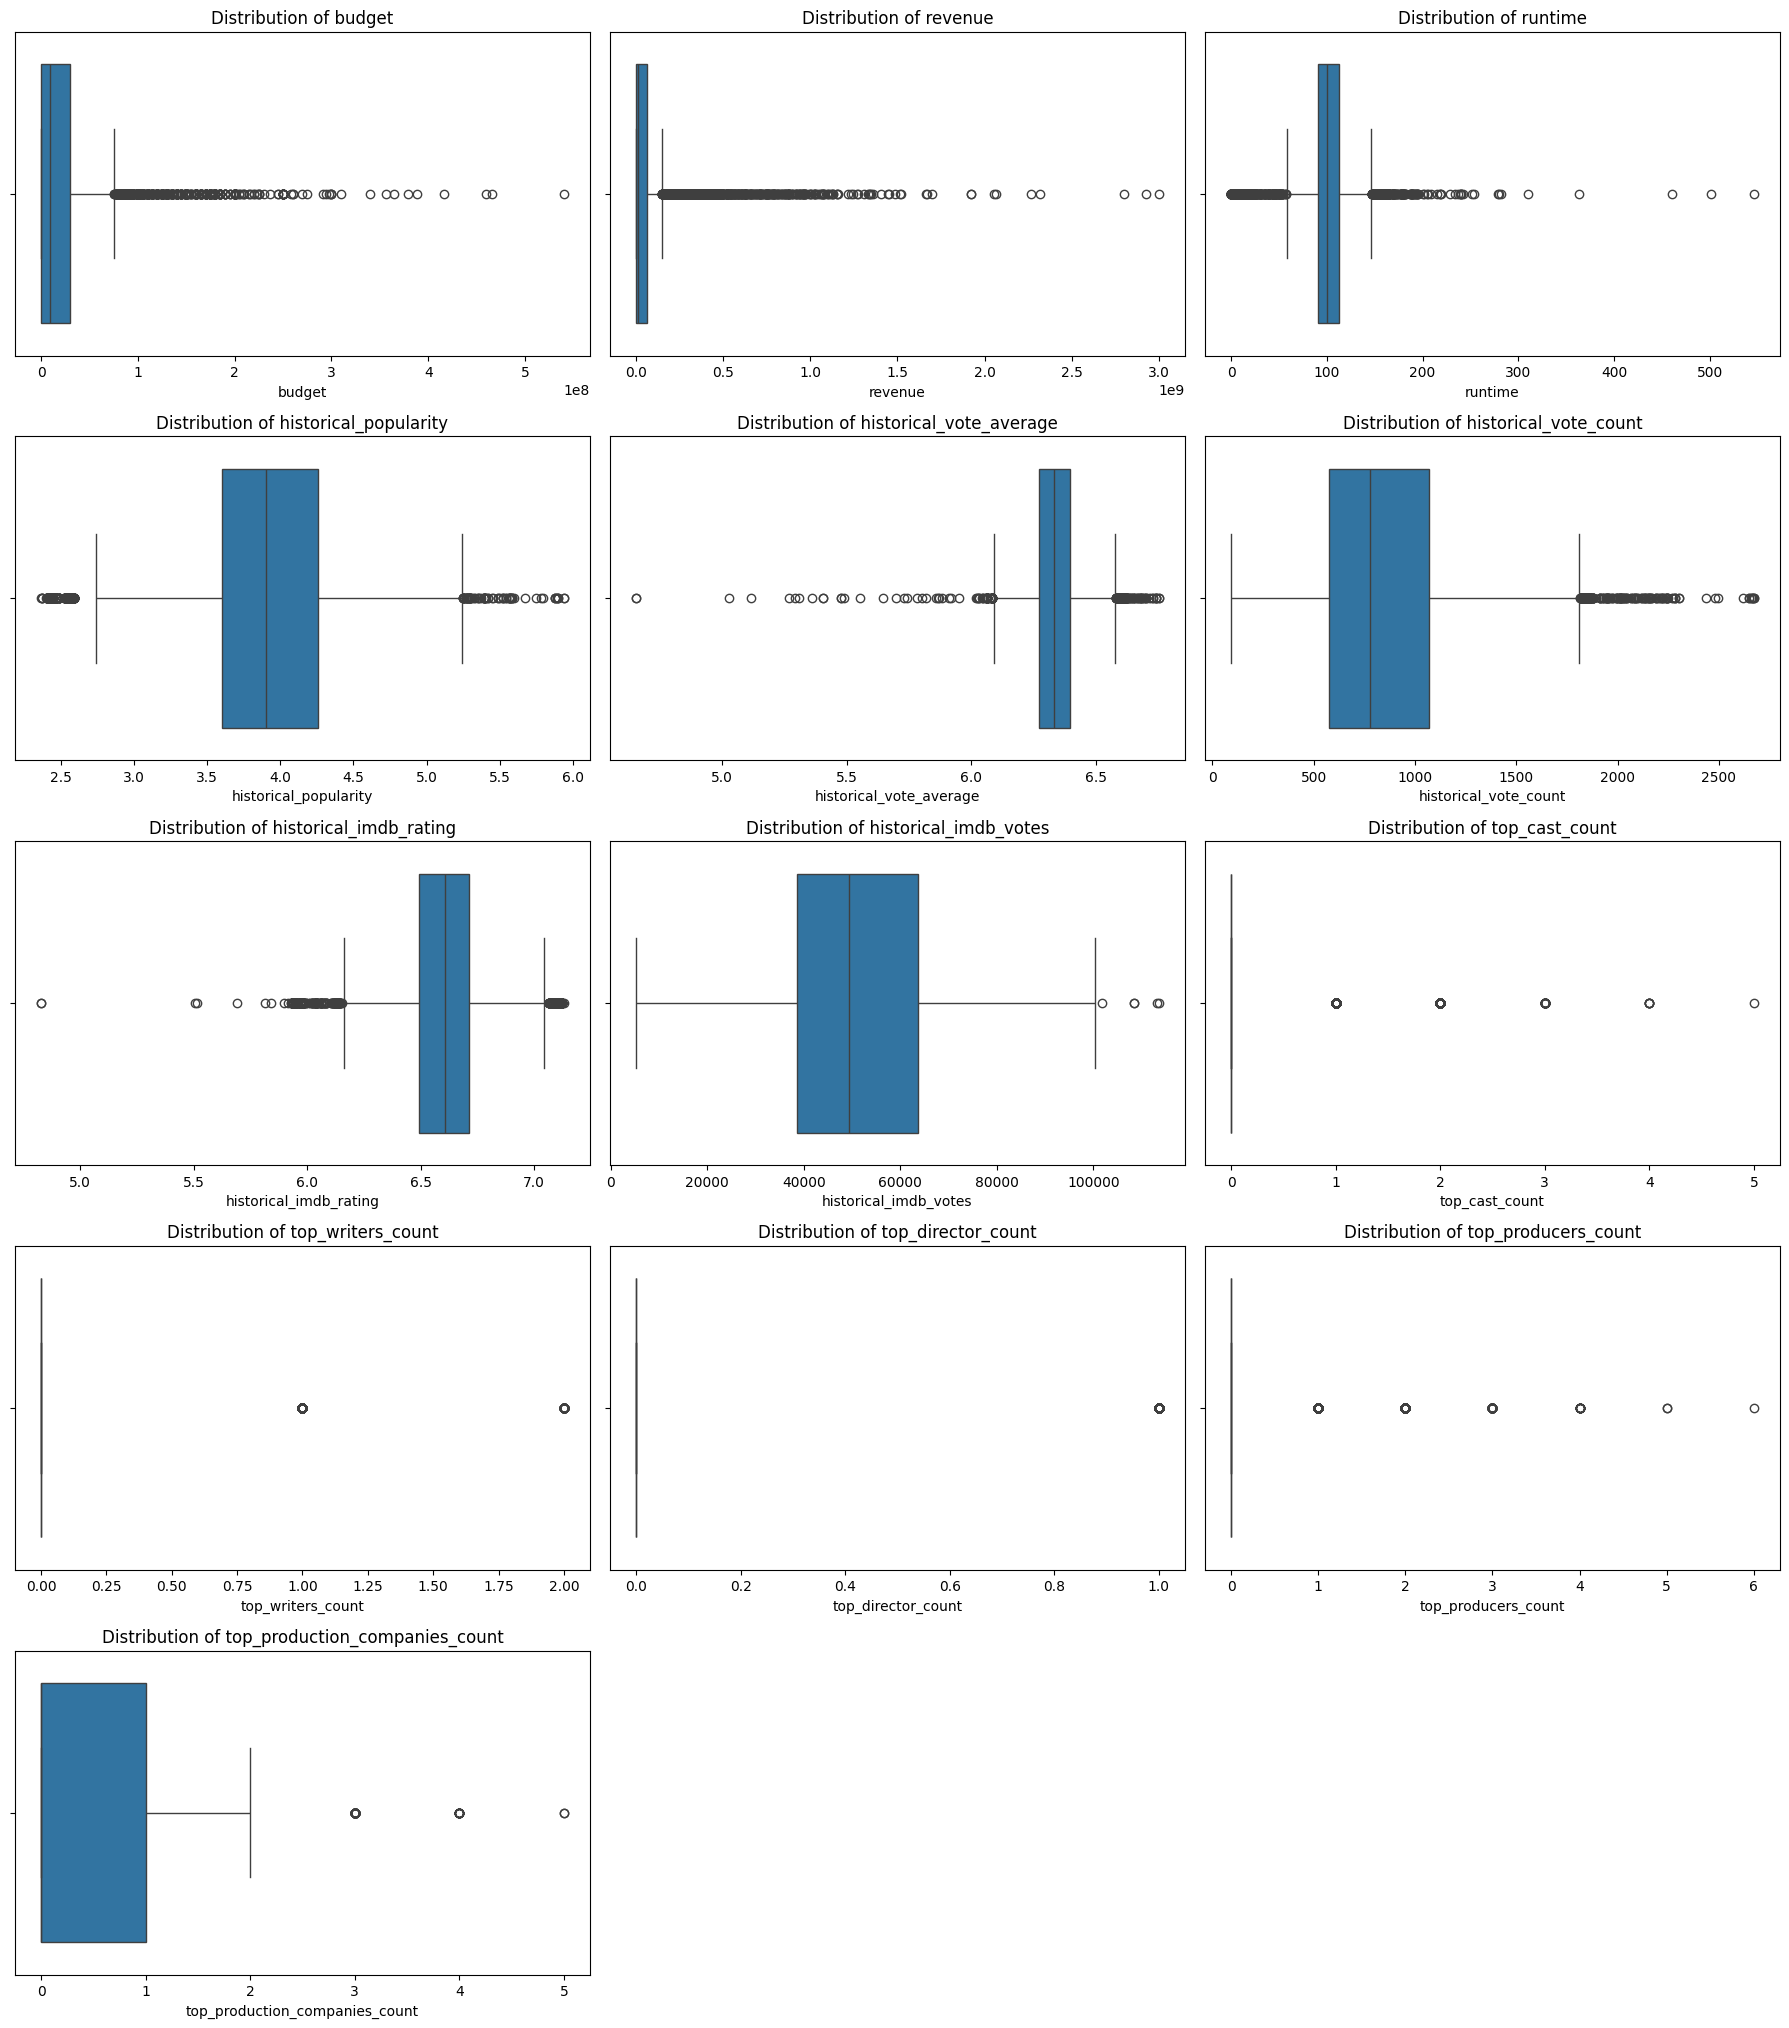

In [ ]:
# Key numerical columns to examine
columns_to_check = [
    'budget', 'revenue', 'runtime',
    'historical_popularity', 'historical_vote_average', 'historical_vote_count',
    'historical_imdb_rating', 'historical_imdb_votes',
    'top_cast_count', 'top_writers_count', 'top_director_count',
    'top_producers_count', 'top_production_companies_count'
]

# Print basic statistics
print(df[columns_to_check].describe().T)

# Plot boxplots to visualize outliers
plt.figure(figsize=(18, 24))
for i, col in enumerate(columns_to_check):
    plt.subplot(6, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

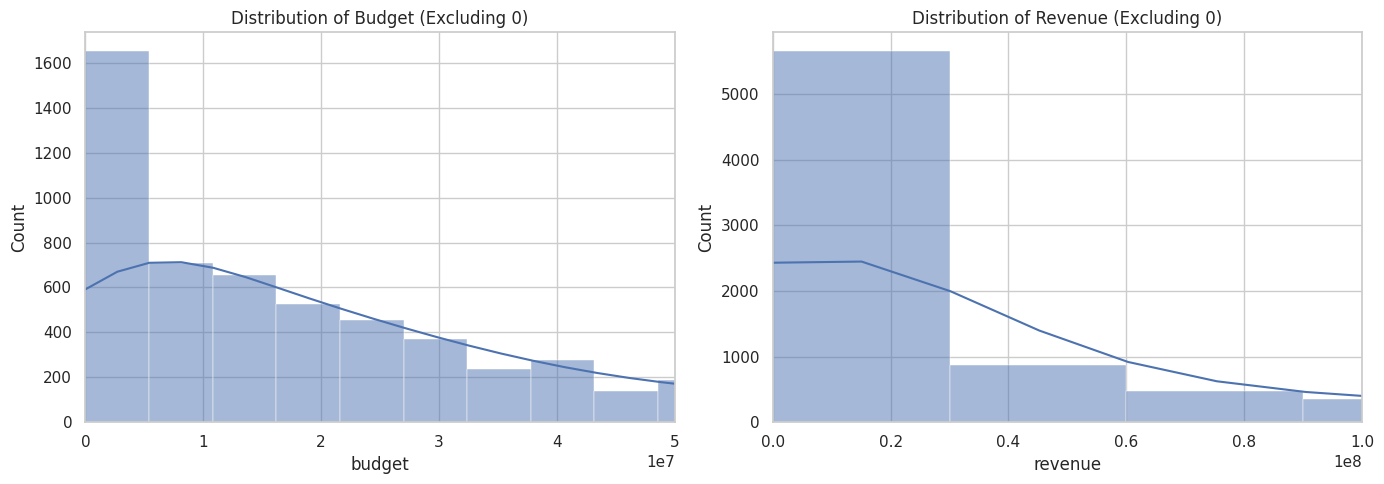


--- BUDGET ---
Threshold:     1,000 → 4.80% rows below
Threshold:    10,000 → 7.79% rows below
Threshold:   100,000 → 9.55% rows below
Threshold: 1,000,000 → 13.19% rows below
Threshold: 10,000,000 → 32.77% rows below

--- REVENUE ---
Threshold:     1,000 → 4.48% rows below
Threshold:    10,000 → 8.46% rows below
Threshold:   100,000 → 18.06% rows below
Threshold: 1,000,000 → 31.45% rows below
Threshold: 10,000,000 → 50.64% rows below


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Filter out 0s separately to inspect them
nonzero_budget = df[df['budget'] > 0]['budget']
nonzero_revenue = df[df['revenue'] > 0]['revenue']

# Plot distribution (after excluding 0)
plt.figure(figsize=(14, 5))

# Budget distribution
plt.subplot(1, 2, 1)
sns.histplot(nonzero_budget, bins=100, kde=True)
plt.xlim(0, 5e7)
plt.title('Distribution of Budget (Excluding 0)')

# Revenue distribution
plt.subplot(1, 2, 2)
sns.histplot(nonzero_revenue, bins=100, kde=True)
plt.xlim(0, 1e8)
plt.title('Distribution of Revenue (Excluding 0)')

plt.tight_layout()
plt.show()

# Cumulative distribution to check drop tradeoffs
for var, name in zip([nonzero_budget, nonzero_revenue], ['budget', 'revenue']):
    print(f"\n--- {name.upper()} ---")
    for threshold in [1e3, 1e4, 1e5, 1e6, 1e7]:
        pct_below = (var < threshold).mean() * 100
        print(f"Threshold: {int(threshold):>9,d} → {pct_below:.2f}% rows below")

## Preprocess univariate anomalies
- Drop rows with budget < 100,000 or revenue < 10,000
- Drop rows with runtime < 30 or runtime > 300
- Apply log transformation to historical_vote_average and budget

In [ ]:
# Drop rows with invalid or extreme runtimes
df = df[(df['runtime'] >= 30) & (df['runtime'] <= 300)]

# Set budget and revenue threshold
budget_cutoff = 100_000
revenue_cutoff = 10_000

# Apply filters
df = df[(df['budget'] >= budget_cutoff) & (df['revenue'] >= revenue_cutoff)]

# Confirm
print("Shape after threshold filtering:", df.shape)
print("Budget min after filtering:", df['budget'].min())
print("Revenue min after filtering:", df['revenue'].min())

# Log transform budget and historical vote count (log1p for safe handling of zeros)
df['budget_log'] = np.log1p(df['budget'])
df['historical_vote_count_log'] = np.log1p(df['historical_vote_count'])

# Confirm
print("Cleaned dataset shape:", df.shape)
print("Columns now include:", list(df.columns))

Shape after threshold filtering: (5774, 40)
Budget min after filtering: 100000.0
Revenue min after filtering: 10018.0
Cleaned dataset shape: (5774, 42)
Columns now include: ['id', 'title', 'revenue', 'runtime', 'budget', 'original_title', 'release_year', 'release_month', 'top_cast_count', 'top_writers_count', 'top_director_count', 'top_producers_count', 'top_production_companies_count', 'historical_vote_average', 'historical_vote_count', 'historical_imdb_votes', 'historical_imdb_rating', 'historical_popularity', 'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller', 'genre_War', 'genre_Western', 'is_english', 'spoken_has_english', 'success', 'budget_log', 'historical_vote_count_log']


In [ ]:
df

,id,title,revenue,runtime,budget,original_title,release_year,release_month,top_cast_count,top_writers_count,...,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,is_english,spoken_has_english,success,budget_log,historical_vote_count_log
0,5,Four Rooms,4257354.0,98.0,4000000.0,Four Rooms,1995.0,12.0,1,0,...,0,0,0,0,0,1,1,0,15.201805,6.094061
1,6,Judgment Night,12136938.0,109.0,21000000.0,Judgment Night,1993.0,10.0,0,0,...,0,0,1,0,0,1,1,0,16.860033,6.511351
2,12,Finding Nemo,940335536.0,100.0,94000000.0,Finding Nemo,2003.0,5.0,1,0,...,0,0,0,0,0,1,1,1,18.358805,7.606822
3,13,Forrest Gump,677387716.0,142.0,55000000.0,Forrest Gump,1994.0,6.0,1,0,...,0,0,0,0,0,1,1,1,17.822844,6.066368
4,14,American Beauty,356296601.0,122.0,15000000.0,American Beauty,1999.0,9.0,0,0,...,0,0,0,0,0,1,1,1,16.523561,6.263342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8645,1379520,Rule Breakers,1503826.0,120.0,15000000.0,Rule Breakers,2025.0,3.0,0,0,...,0,0,0,0,0,1,1,0,16.523561,6.590741
8650,1380415,The Last Supper,6254291.0,114.0,8000000.0,The Last Supper,2025.0,3.0,0,0,...,0,0,0,0,0,1,1,0,15.894952,6.670880
8676,1416532,Martin,210000000.0,128.0,103000000.0,Martin,2025.0,1.0,0,0,...,0,0,0,0,0,1,1,0,18.450240,6.879195
8683,1421494,Mortal Kombat Legacy,557015.0,104.0,100000.0,Mortal Kombat Legacy,2011.0,4.0,0,0,...,1,0,0,0,0,1,1,1,11.512935,7.193297


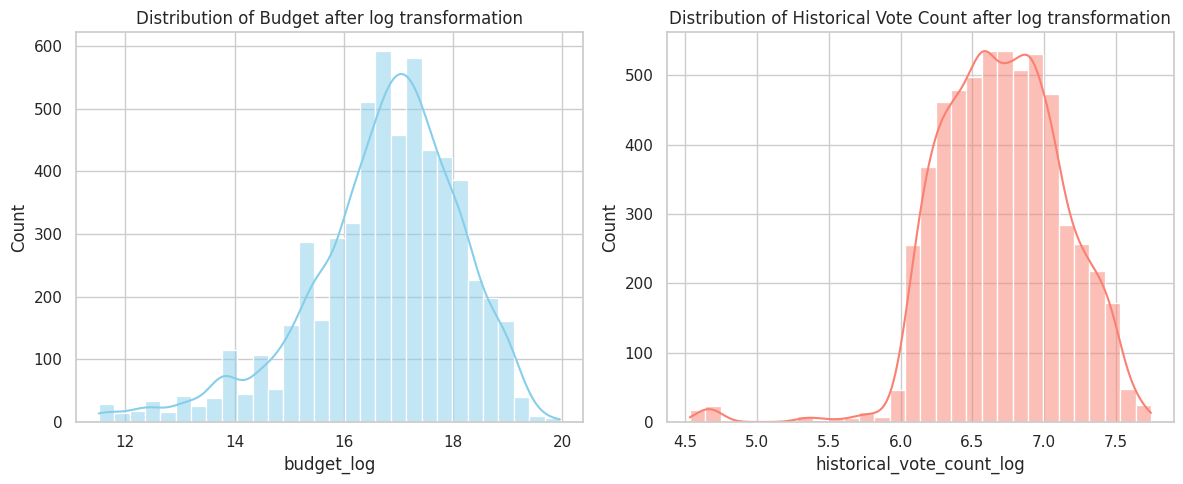

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Create the plots
plt.figure(figsize=(12, 5))

# Plot budget_log
plt.subplot(1, 2, 1)
sns.histplot(df['budget_log'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Budget after log transformation')
plt.xlabel('budget_log')

# Plot historical_vote_count_log
plt.subplot(1, 2, 2)
sns.histplot(df['historical_vote_count_log'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Historical Vote Count after log transformation')
plt.xlabel('historical_vote_count_log')

plt.tight_layout()
plt.show()

## Isolation Forest for multivariate anomalies

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define final features for Isolation Forest
iso_features = [
    'budget_log',
    'runtime',
    'historical_popularity',
    'historical_vote_count_log',
    'historical_vote_average',
    'historical_imdb_rating',
    'top_cast_count',
    'top_director_count',
    'top_producers_count',
    'top_production_companies_count'
]

# Step 2: Subset data (drop missing just in case)
X_iso = df[iso_features].dropna()

# Step 3: Run Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # Detect ~1% of anomalies
    random_state=42
)
df['iso_outlier'] = -1  # Default value

# Predict on clean subset only
iso_labels = iso_forest.fit_predict(X_iso)
df.loc[X_iso.index, 'iso_outlier'] = (iso_labels == -1).astype(int)

# Step 4: Print summary
print(f"Isolation Forest applied. Total outliers detected: {df['iso_outlier'].sum()} out of {len(df)} rows.")

Isolation Forest applied. Total outliers detected: 58 out of 5774 rows.


📊 Relative difference between outliers and inliers:


,Feature,Inlier Mean,Outlier Mean,Relative % Difference
7,top_director_count,0.062456,0.396552,534.927074
6,top_cast_count,0.290938,0.689655,137.045638
8,top_producers_count,0.336949,0.741379,120.027214
9,top_production_companies_count,0.763471,1.000000,30.980752
2,historical_popularity,4.001141,3.288133,-17.820118
1,runtime,107.375262,124.500000,15.948494
3,historical_vote_count_log,6.713839,5.734888,-14.581084
0,budget_log,16.744330,15.684244,-6.331013
5,historical_imdb_rating,6.578314,6.814429,3.589290
4,historical_vote_average,6.347098,6.256366,-1.429497


<ipython-input-37-83fa9cead546>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


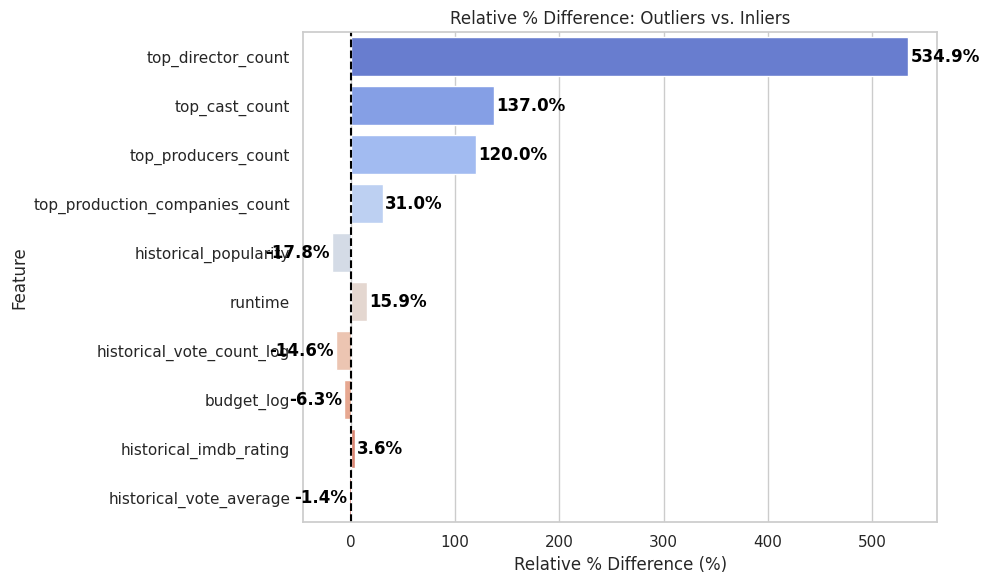

In [ ]:
# Step 1: Separate outliers and inliers
outliers_df = df[df['iso_outlier'] == 1]
inliers_df = df[df['iso_outlier'] == 0]

# Step 2: Compute mean values for each feature
outlier_means = outliers_df[iso_features].mean()
inlier_means = inliers_df[iso_features].mean()

# Step 3: Compute percentage difference
percent_diff = ((outlier_means - inlier_means) / inlier_means) * 100

# Step 4: Assemble summary table
summary_df = pd.DataFrame({
    'Feature': iso_features,
    'Inlier Mean': inlier_means.values,
    'Outlier Mean': outlier_means.values,
    'Relative % Difference': percent_diff.values
}).sort_values(by='Relative % Difference', key=abs, ascending=False)

# Display results
print("📊 Relative difference between outliers and inliers:")
display(summary_df)

# Sort data for consistent labeling
sorted_df = summary_df.sort_values(by='Relative % Difference', key=abs, ascending=False)

# Create barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=sorted_df,
    x='Relative % Difference',
    y='Feature',
    palette='coolwarm'
)
plt.title('Relative % Difference: Outliers vs. Inliers')
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('Relative % Difference (%)')
plt.ylabel('Feature')

# Add percentage labels on each bar
for i, value in enumerate(sorted_df['Relative % Difference']):
    ax.text(
        value + (2 if value >= 0 else -2),  # slight offset
        i,
        f"{value:.1f}%",
        color='black',
        va='center',
        ha='left' if value >= 0 else 'right',
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

In [ ]:
# Calculate 25th percentile of popularity to define "low"
popularity_threshold = df['historical_popularity'].quantile(0.25)

# Filter outliers matching the multivariate edge pattern
representative_outliers = df[
    (df['iso_outlier'] == 1) &
    (df['top_director_count'] >= 1) &
    (df['top_cast_count'] >= 1) &
    (df['top_producers_count'] >= 1) &
    (df['historical_popularity'] <= popularity_threshold)
]

# Columns to show
cols_to_show = [
    'title', 'budget', 'runtime', 'historical_popularity',
    'top_cast_count', 'top_director_count', 'top_producers_count',
    'historical_vote_count', 'historical_vote_average', 'success'
]

# Display the rows
print("🎯 Representative Outlier Edge Cases (High-profile but Low-popularity):")
display(representative_outliers[cols_to_show].sort_values(
    by=['top_director_count', 'top_cast_count'], ascending=False).head(5))

🎯 Representative Outlier Edge Cases (High-profile but Low-popularity):


,title,budget,runtime,historical_popularity,top_cast_count,top_director_count,top_producers_count,historical_vote_count,historical_vote_average,success
601,The Aviator,110000000.0,170.0,3.470791,2,1,2,565.674011,6.392169,0
1036,Bringing Out the Dead,32000000.0,121.0,3.405264,2,1,1,523.970624,6.400520,0
164,Apollo 13,52000000.0,140.0,3.500770,1,1,1,510.848896,6.555374,1


In [ ]:
# Display all rows classified as outliers
print("Outlier sample rows (iso_outlier == 1):")
display(df[df['iso_outlier'] == 1].sort_values(by='budget_log', ascending=False))

Outlier sample rows (iso_outlier == 1):


,id,title,revenue,runtime,budget,original_title,release_year,release_month,top_cast_count,top_writers_count,...,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,is_english,spoken_has_english,success,budget_log,historical_vote_count_log,iso_outlier
8512,1270893,TikTok Rizz Party,3.000000e+09,180.0,250000000.0,TikTok Rizz Party,2024.0,4.0,1,0,...,0,0,0,0,1,0,1,19.336971,6.601852,1
6022,335988,Transformers: The Last Knight,6.054252e+08,154.0,217000000.0,Transformers: The Last Knight,2017.0,6.0,4,1,...,0,0,0,0,1,1,1,19.195408,7.411706,1
4774,91314,Transformers: Age of Extinction,1.104054e+09,165.0,210000000.0,Transformers: Age of Extinction,2014.0,6.0,3,0,...,0,0,0,0,1,1,1,19.162618,7.295817,1
7490,693134,Dune: Part Two,7.144444e+08,167.0,190000000.0,Dune: Part Two,2024.0,2.0,2,0,...,0,0,0,0,1,1,1,19.062535,7.600035,1
5991,333339,Ready Player One,6.072741e+08,140.0,175000000.0,Ready Player One,2018.0,3.0,0,0,...,0,0,0,0,1,1,1,18.980297,7.441384,1
6322,398978,The Irishman,9.688530e+05,209.0,159000000.0,The Irishman,2019.0,11.0,2,0,...,0,0,0,0,1,1,0,18.884415,6.741609,1
5615,267935,The BFG,1.952434e+08,117.0,140000000.0,The BFG,2016.0,6.0,0,0,...,0,0,0,0,1,1,0,18.757153,7.520416,1
2802,17578,The Adventures of Tintin,3.739940e+08,107.0,130000000.0,The Adventures of Tintin,2011.0,10.0,0,0,...,0,0,0,0,1,1,1,18.683045,7.429783,1
44,163,Ocean's Twelve,3.627443e+08,125.0,110000000.0,Ocean's Twelve,2004.0,12.0,2,0,...,0,1,0,0,1,1,1,18.515991,6.751845,1
601,2567,The Aviator,2.137000e+08,170.0,110000000.0,The Aviator,2004.0,12.0,2,0,...,0,0,0,0,1,1,0,18.515991,6.339784,1


In [ ]:
# Set Google Drive export path
export_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/final_transformed_dataset.csv'

# Export the DataFrame
df.to_csv(export_path, index=False)
print(f"✅ Dataset exported to: {export_path}")

✅ Dataset exported to: /content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/final_transformed_dataset.csv


# Train-test split
- We'll have two test sets, one for normal cases, and the other for edge cases.
- Training set will contain 80% normal cases and 80% edge cases, while testing set will contain 20% normal cases and 20% edge cases.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Split by outlier group
normal_df = df[df['iso_outlier'] == 0]
edge_df = df[df['iso_outlier'] == 1]

# Step 2: Stratified split within each group
normal_train, normal_test = train_test_split(
    normal_df,
    test_size=0.2,
    stratify=normal_df['success'],
    random_state=42
)

edge_train, edge_test = train_test_split(
    edge_df,
    test_size=0.2,
    stratify=edge_df['success'],
    random_state=42
)

# Step 3: Combine full training set
train_df = pd.concat([normal_train, edge_train]).reset_index(drop=True)

# Step 4: Export separate test sets
test_normal_df = normal_test.reset_index(drop=True)
test_edge_df = edge_test.reset_index(drop=True)

print("📊 Dataset Summary:")
print("✅ Training Set Total:", train_df.shape[0])
print("   - Normal cases:", (train_df['iso_outlier'] == 0).sum())
print("   - Edge cases  :", (train_df['iso_outlier'] == 1).sum())
print("✅ Test Set (Normal):", test_normal_df.shape[0])
print("   - Normal cases:", (test_normal_df['iso_outlier'] == 0).sum())
print("✅ Test Set (Edge):", test_edge_df.shape[0])
print("   - Edge cases  :", (test_edge_df['iso_outlier'] == 1).sum())

📊 Dataset Summary:
✅ Training Set Total: 4618
   - Normal cases: 4572
   - Edge cases  : 46
✅ Test Set (Normal): 1144
   - Normal cases: 1144
✅ Test Set (Edge): 12
   - Edge cases  : 12


In [ ]:
# Step 5: Export all sets to Google Drive
train_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/train_set.csv'
test_normal_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/test_set_normal.csv'
test_edge_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/test_set_edge.csv'

train_df.to_csv(train_path, index=False)
test_normal_df.to_csv(test_normal_path, index=False)
test_edge_df.to_csv(test_edge_path, index=False)

print(f"📁 Train set saved to: {train_path}")
print(f"📁 Normal test set saved to: {test_normal_path}")
print(f"📁 Edge test set saved to: {test_edge_path}")

📁 Train set saved to: /content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/train_set.csv
📁 Normal test set saved to: /content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/test_set_normal.csv
📁 Edge test set saved to: /content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/test_set_edge.csv


# Model Training

In [3]:
import pandas as pd

# Define paths
base_path = '/content/drive/MyDrive/ADS/Machine Learning II/Machine Learning II_Project/Model_Data'

train_path = f'{base_path}/train_set.csv'
test_normal_path = f'{base_path}/test_set_normal.csv'
test_edge_path = f'{base_path}/test_set_edge.csv'

# Load datasets
train_df = pd.read_csv(train_path)
test_normal_df = pd.read_csv(test_normal_path)
test_edge_df = pd.read_csv(test_edge_path)

# Confirm shape
print("✅ Train set loaded:", train_df.shape)
print("✅ Test set (normal) loaded:", test_normal_df.shape)
print("✅ Test set (edge) loaded:", test_edge_df.shape)

✅ Train set loaded: (4618, 43)
✅ Test set (normal) loaded: (1144, 43)
✅ Test set (edge) loaded: (12, 43)


In [ ]:
train_df.columns

Index(['id', 'title', 'revenue', 'runtime', 'budget', 'original_title',
       'release_year', 'release_month', 'top_cast_count', 'top_writers_count',
       'top_director_count', 'top_producers_count',
       'top_production_companies_count', 'historical_vote_average',
       'historical_vote_count', 'historical_imdb_votes',
       'historical_imdb_rating', 'historical_popularity', 'genre_Action',
       'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy',
       'genre_History', 'genre_Horror', 'genre_Music', 'genre_Mystery',
       'genre_Romance', 'genre_Science_Fiction', 'genre_TV_Movie',
       'genre_Thriller', 'genre_War', 'genre_Western', 'is_english',
       'spoken_has_english', 'success', 'budget_log',
       'historical_vote_count_log', 'iso_outlier'],
      dtype='object')

In [4]:
# Define target and predictors
target_col = 'success'

feature_cols = [
    # Log-transformed numerical
    'budget_log', 'historical_vote_count_log',

    # Temporal features
    'release_year', 'release_month',

    # Other numeric predictors
    'runtime', 'historical_vote_average', 'historical_imdb_rating', 'historical_imdb_votes',
    'historical_popularity',

    # Cast/crew info
    'top_cast_count', 'top_writers_count', 'top_director_count',
    'top_producers_count', 'top_production_companies_count',

    # Language indicators
    'is_english', 'spoken_has_english',

    # One-hot encoded genres
    'genre_Action', 'genre_Adventure', 'genre_Animation', 'genre_Comedy', 'genre_Crime',
    'genre_Documentary', 'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_History',
    'genre_Horror', 'genre_Music', 'genre_Mystery', 'genre_Romance', 'genre_Science_Fiction',
    'genre_TV_Movie', 'genre_Thriller', 'genre_War', 'genre_Western'
]

# Apply to each dataset
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test_normal = test_normal_df[feature_cols]
y_test_normal = test_normal_df[target_col]

X_test_edge = test_edge_df[feature_cols]
y_test_edge = test_edge_df[target_col]

print("Features and target defined (with release_year and release_month).")
print("X_train shape:", X_train.shape)

Features and target defined (with release_year and release_month).
X_train shape: (4618, 35)


## Logistic Regression (balanced)

In [5]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform all datasets
X_train_scaled = scaler.fit_transform(X_train)
X_test_normal_scaled = scaler.transform(X_test_normal)
X_test_edge_scaled = scaler.transform(X_test_edge)

print("StandardScaler applied to training and test sets for logistic regression.")
print("Scaled X_train shape:", X_train_scaled.shape)

StandardScaler applied to training and test sets for logistic regression.
Scaled X_train shape: (4618, 35)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define and train the logistic regression model
logreg = LogisticRegression(
    C=1.0,
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)
logreg.fit(X_train_scaled, y_train)

# Step 2: Predict and probability scores
y_pred_logreg_normal = logreg.predict(X_test_normal_scaled)
y_pred_logreg_edge = logreg.predict(X_test_edge_scaled)
y_prob_logreg_normal = logreg.predict_proba(X_test_normal_scaled)[:, 1]
y_prob_logreg_edge = logreg.predict_proba(X_test_edge_scaled)[:, 1]

# Step 3: Compute evaluation metrics and store results
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'FPR': roc_curve(y_true, y_prob)[0],
        'TPR': roc_curve(y_true, y_prob)[1]
    }

logreg_results = {
    'normal': compute_metrics(y_test_normal, y_pred_logreg_normal, y_prob_logreg_normal),
    'edge': compute_metrics(y_test_edge, y_pred_logreg_edge, y_prob_logreg_edge)
}

# Logistic Regression Evaluation (with Confusion Matrix)
print("\n📊 Logistic Regression - Normal Test Set:")
for metric, value in logreg_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 Logistic Regression - Edge Test Set:")
for metric, value in logreg_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 Logistic Regression - Normal Test Set:
Accuracy: 0.5997
Recall: 0.5503
Precision: 0.4398
F1 Score: 0.4888
Confusion Matrix:
[[467 279]
 [179 219]]
AUC: 0.6458

📊 Logistic Regression - Edge Test Set:
Accuracy: 0.5000
Recall: 1.0000
Precision: 0.5000
F1 Score: 0.6667
Confusion Matrix:
[[0 6]
 [0 6]]
AUC: 0.5000


# Decision Tree (CART)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Enhanced Hyperparameter tuning grid
param_grid = {
    'max_depth': [5, 10, 15, 20, None],               # deeper trees
    'min_samples_split': [2, 5, 10, 20],              # stricter split conditions
    'min_samples_leaf': [1, 2, 5, 10],                # prevents overfitting on small leaves
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01, 0.05]       # fine-grained pruning
}

grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_

print("✅ Best decision tree parameters:")
print(grid.best_params_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
✅ Best decision tree parameters:
{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

# Step 1: Predict
y_pred_cart_normal = best_tree.predict(X_test_normal)
y_pred_cart_edge = best_tree.predict(X_test_edge)

# Step 2: Predict probabilities
y_prob_cart_normal = best_tree.predict_proba(X_test_normal)[:, 1]
y_prob_cart_edge = best_tree.predict_proba(X_test_edge)[:, 1]

# Step 3: Define reusable metric computation
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'FPR': roc_curve(y_true, y_prob)[0],
        'TPR': roc_curve(y_true, y_prob)[1]
    }

# Step 4: Store metrics
cart_results = {
    'normal': compute_metrics(y_test_normal, y_pred_cart_normal, y_prob_cart_normal),
    'edge': compute_metrics(y_test_edge, y_pred_cart_edge, y_prob_cart_edge)
}

# Decision Tree Evaluation (with Confusion Matrix)
print("\n📊 Decision Tree - Normal Test Set:")
for metric, value in cart_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 Decision Tree - Edge Test Set:")
for metric, value in cart_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 Decision Tree - Normal Test Set:
Accuracy: 0.5935
Recall: 0.4447
Precision: 0.4204
F1 Score: 0.4322
Confusion Matrix:
[[502 244]
 [221 177]]
AUC: 0.5588

📊 Decision Tree - Edge Test Set:
Accuracy: 0.1667
Recall: 0.3333
Precision: 0.2500
F1 Score: 0.2857
Confusion Matrix:
[[0 6]
 [4 2]]
AUC: 0.1667


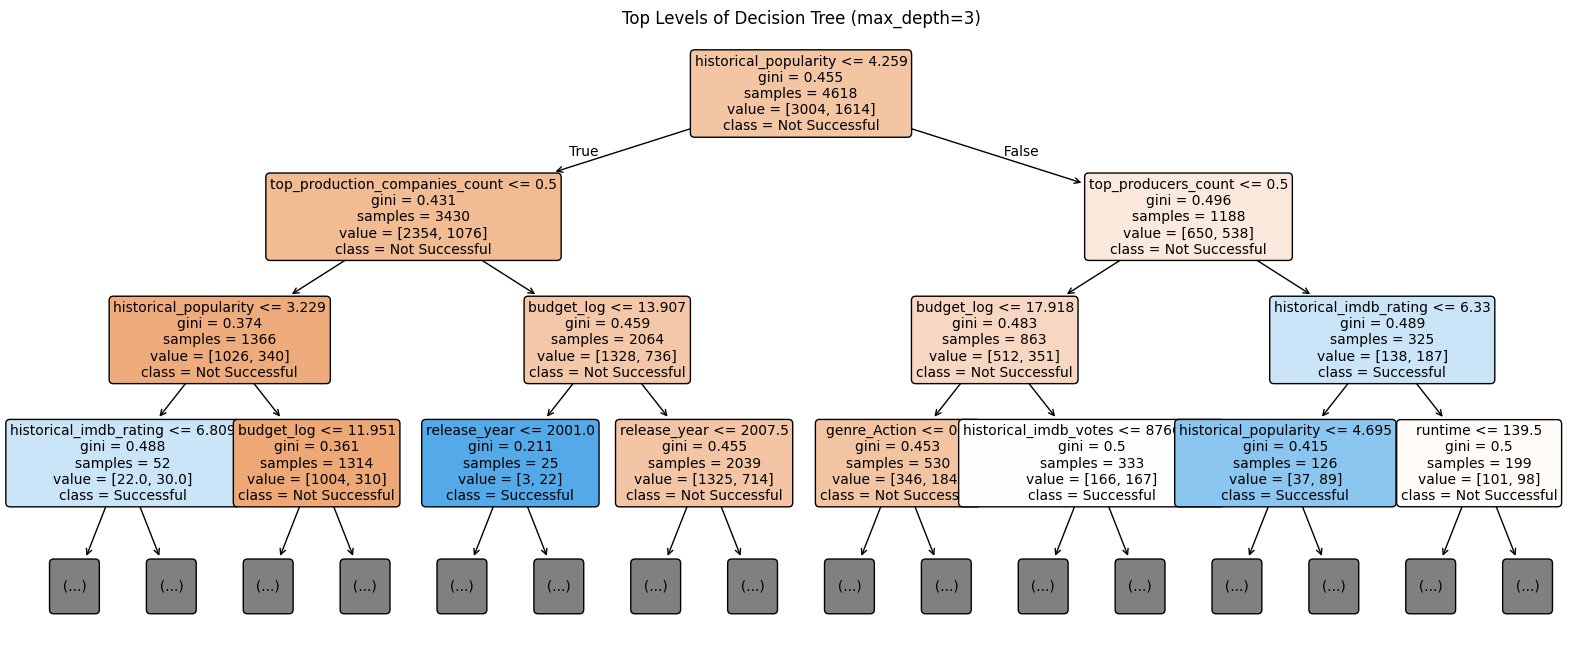

In [ ]:
# Step 6: Visualize the decision tree
plt.figure(figsize=(20, 8))
plot_tree(best_tree, feature_names=X_train.columns, class_names=["Not Successful", "Successful"],
          filled=True, max_depth=3, rounded=True, fontsize=10)
plt.title("Top Levels of Decision Tree (max_depth=3)")
plt.show()

,Feature,Importance
0,budget_log,0.124879
4,runtime,0.115132
6,historical_imdb_rating,0.095295
8,historical_popularity,0.092899
5,historical_vote_average,0.083239
2,release_year,0.080668
7,historical_imdb_votes,0.078856
3,release_month,0.077337
1,historical_vote_count_log,0.072071
13,top_production_companies_count,0.030372


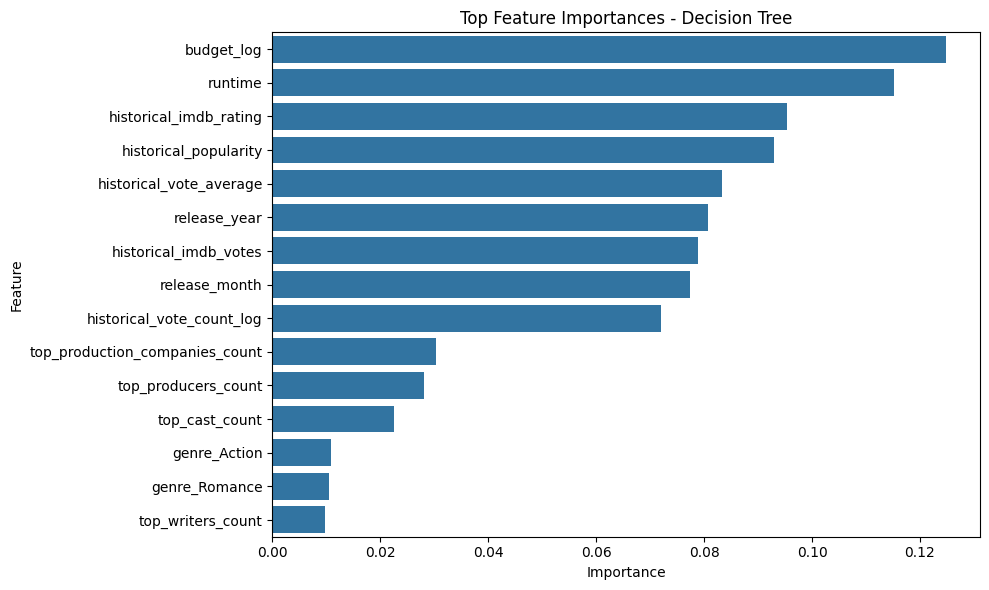

In [ ]:
import pandas as pd

# Create a sorted DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title("Top Feature Importances - Decision Tree")
plt.tight_layout()
plt.show()

## Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
✅ Best Random Forest parameters:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}

📊 Evaluation: Normal Test Set
Accuracy : 0.6320
Recall   : 0.4698
Precision: 0.4710
F1 Score : 0.4704
Confusion Matrix:
[[536 210]
 [211 187]]

📊 Evaluation: Edge Test Set
Accuracy : 0.3333
Recall   : 0.5000
Precision: 0.3750
F1 Score : 0.4286
Confusion Matrix:
[[1 5]
 [3 3]]

🌟 Top Feature Importances:


,Feature,Importance
8,historical_popularity,0.101627
4,runtime,0.101234
6,historical_imdb_rating,0.091461
0,budget_log,0.090825
1,historical_vote_count_log,0.090635
5,historical_vote_average,0.086634
2,release_year,0.079116
7,historical_imdb_votes,0.078793
13,top_production_companies_count,0.055701
3,release_month,0.044769


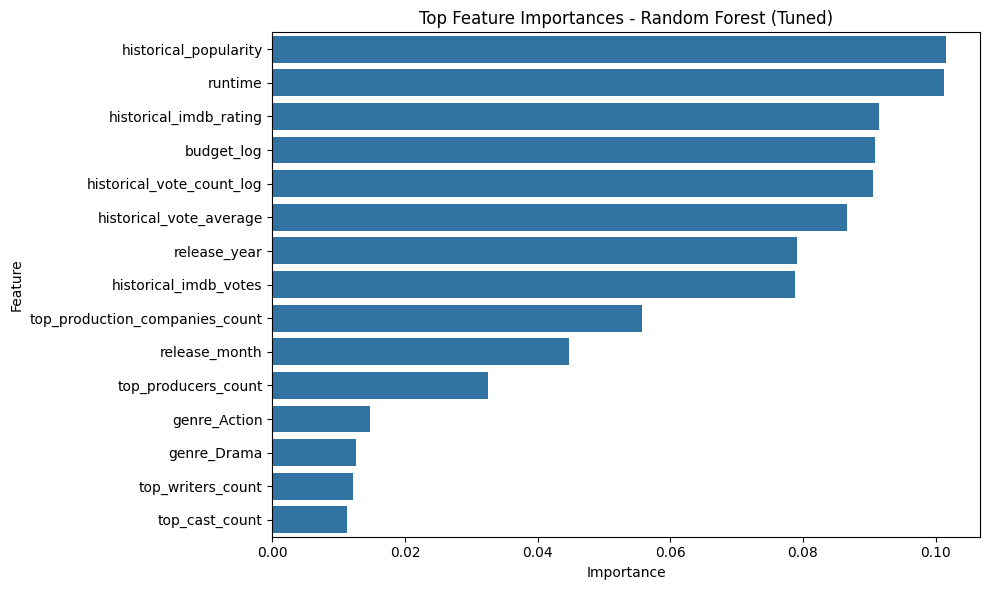

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Enhanced hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2']
}

# Step 2: GridSearchCV with class_weight balanced
grid_rf = GridSearchCV(
    RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)

# Fit model
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("✅ Best Random Forest parameters:")
print(grid_rf.best_params_)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

# Step 1: Predict
y_pred_rf_normal = best_rf.predict(X_test_normal)
y_pred_rf_edge = best_rf.predict(X_test_edge)

# Step 2: Probabilities
y_prob_rf_normal = best_rf.predict_proba(X_test_normal)[:, 1]
y_prob_rf_edge = best_rf.predict_proba(X_test_edge)[:, 1]

# Step 3: Metrics function
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'FPR': roc_curve(y_true, y_prob)[0],
        'TPR': roc_curve(y_true, y_prob)[1]
    }

# Step 4: Store metrics
rf_results = {
    'normal': compute_metrics(y_test_normal, y_pred_rf_normal, y_prob_rf_normal),
    'edge': compute_metrics(y_test_edge, y_pred_rf_edge, y_prob_rf_edge)
}

# Step 5: Print all metrics (including confusion matrix)
print("\n📊 Random Forest - Normal Test Set:")
for metric, value in rf_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 Random Forest - Edge Test Set:")
for metric, value in rf_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 Random Forest - Normal Test Set:
Accuracy: 0.6320
Recall: 0.4698
Precision: 0.4710
F1 Score: 0.4704
Confusion Matrix:
[[536 210]
 [211 187]]
AUC: 0.6459

📊 Random Forest - Edge Test Set:
Accuracy: 0.3333
Recall: 0.5000
Precision: 0.3750
F1 Score: 0.4286
Confusion Matrix:
[[1 5]
 [3 3]]
AUC: 0.3889



🌟 Top Feature Importances:


,Feature,Importance
8,historical_popularity,0.101627
4,runtime,0.101234
6,historical_imdb_rating,0.091461
0,budget_log,0.090825
1,historical_vote_count_log,0.090635
5,historical_vote_average,0.086634
2,release_year,0.079116
7,historical_imdb_votes,0.078793
13,top_production_companies_count,0.055701
3,release_month,0.044769


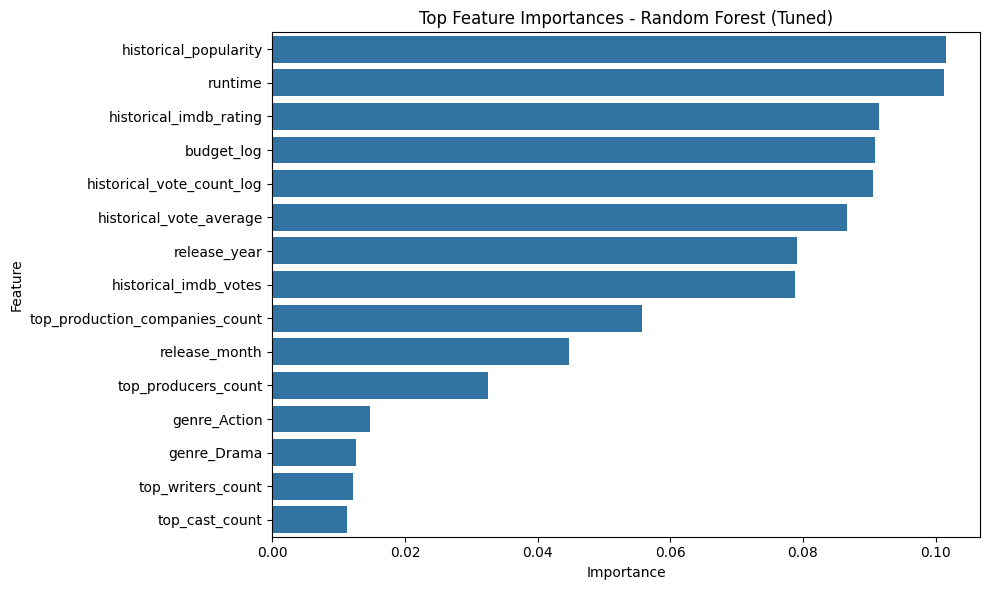

In [ ]:
# Step 7: Plot Feature Importance
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n🌟 Top Feature Importances:")
display(importances.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances.head(15))
plt.title("Top Feature Importances - Random Forest (Tuned)")
plt.tight_layout()
plt.show()

## XGBoost

In [ ]:
!pip install --quiet xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Step 1: Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Estimate class imbalance ratio for scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Step 2: GridSearch with class imbalance adjustment
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1
)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_

print("✅ Best XGBoost parameters:")
print(grid_xgb.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
✅ Best XGBoost parameters:
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

# Step 1: Predict
y_pred_xgb_normal = best_xgb.predict(X_test_normal)
y_pred_xgb_edge = best_xgb.predict(X_test_edge)

# Step 2: Probabilities
y_prob_xgb_normal = best_xgb.predict_proba(X_test_normal)[:, 1]
y_prob_xgb_edge = best_xgb.predict_proba(X_test_edge)[:, 1]

# Step 3: Reusable evaluation function
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'FPR': roc_curve(y_true, y_prob)[0],
        'TPR': roc_curve(y_true, y_prob)[1]
    }

# Step 4: Store metrics
xgb_results = {
    'normal': compute_metrics(y_test_normal, y_pred_xgb_normal, y_prob_xgb_normal),
    'edge': compute_metrics(y_test_edge, y_pred_xgb_edge, y_prob_xgb_edge)
}

# Step 5: Print metrics with confusion matrix
print("\n📊 XGBoost - Normal Test Set:")
for metric, value in xgb_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 XGBoost - Edge Test Set:")
for metric, value in xgb_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 XGBoost - Normal Test Set:
Accuracy: 0.6495
Recall: 0.5578
Precision: 0.4966
F1 Score: 0.5254
Confusion Matrix:
[[521 225]
 [176 222]]
AUC: 0.6705

📊 XGBoost - Edge Test Set:
Accuracy: 0.4167
Recall: 0.3333
Precision: 0.4000
F1 Score: 0.3636
Confusion Matrix:
[[3 3]
 [4 2]]
AUC: 0.3611


### XGBoost Feature Importance on Normal Cases (SHAP)

<ipython-input-36-52ff4f7b4f4e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=shap_importance_df, x='SHAP Value', y='Feature', palette='Purples_d')


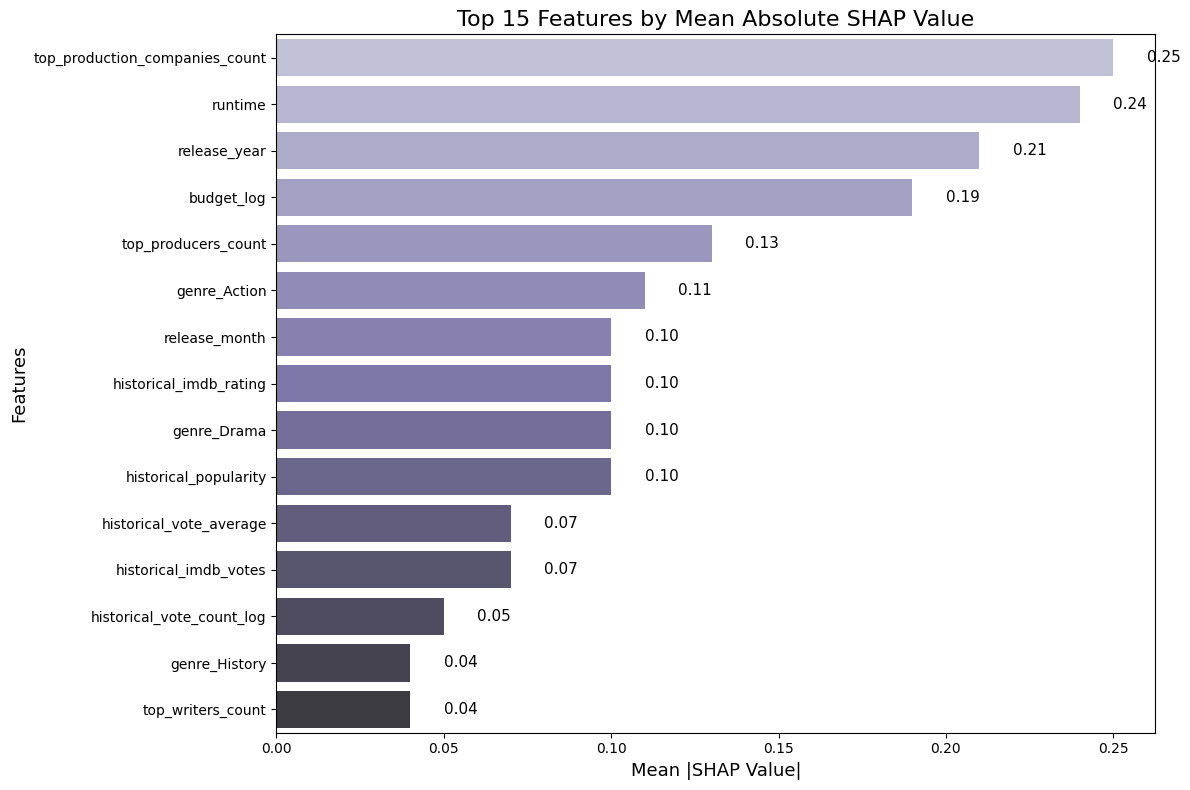

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute SHAP values using TreeExplainer
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_normal)

# Compute mean absolute SHAP values for top 15 features
shap_df = pd.DataFrame(shap_values, columns=X_test_normal.columns)
mean_shap = shap_df.abs().mean().sort_values(ascending=False).head(15).round(2)
shap_importance_df = pd.DataFrame({
    'Feature': mean_shap.index,
    'SHAP Value': mean_shap.values
})

# Plot with Seaborn and annotate
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=shap_importance_df, x='SHAP Value', y='Feature', palette='Purples_d')

# Add SHAP value labels (2 decimal places)
for i, (val, feature) in enumerate(zip(shap_importance_df['SHAP Value'], shap_importance_df['Feature'])):
    plt.text(val + 0.01, i, f"{val:.2f}", va='center', fontsize=11)

plt.title("Top 15 Features by Mean Absolute SHAP Value", fontsize=16)
plt.xlabel("Mean |SHAP Value|", fontsize=13)
plt.ylabel("Features", fontsize=13)
plt.tight_layout()
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Parameter tuning grid (linear and RBF kernels)
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # only applies to 'rbf'
}

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Step 2: Fit on scaled training data
grid_svm.fit(X_train_scaled, y_train)
best_svm = grid_svm.best_estimator_

print("✅ Best SVM parameters:")
print(grid_svm.best_params_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ Best SVM parameters:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# Step 1: Predict
y_pred_svm_normal = best_svm.predict(X_test_normal_scaled)
y_pred_svm_edge = best_svm.predict(X_test_edge_scaled)

# Step 2: Probabilities
y_prob_svm_normal = best_svm.predict_proba(X_test_normal_scaled)[:, 1]
y_prob_svm_edge = best_svm.predict_proba(X_test_edge_scaled)[:, 1]

# Step 3: Compute metrics
def compute_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob),
        'FPR': roc_curve(y_true, y_prob)[0],
        'TPR': roc_curve(y_true, y_prob)[1]
    }

svm_results = {
    'normal': compute_metrics(y_test_normal, y_pred_svm_normal, y_prob_svm_normal),
    'edge': compute_metrics(y_test_edge, y_pred_svm_edge, y_prob_svm_edge)
}

# Step 4: Print
print("\n📊 SVM - Normal Test Set:")
for metric, value in svm_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 SVM - Edge Test Set:")
for metric, value in svm_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 SVM - Normal Test Set:
Accuracy: 0.6617
Recall: 0.3241
Precision: 0.5223
F1 Score: 0.4000
Confusion Matrix:
[[628 118]
 [269 129]]
AUC: 0.6376

📊 SVM - Edge Test Set:
Accuracy: 0.5833
Recall: 0.5000
Precision: 0.6000
F1 Score: 0.5455
Confusion Matrix:
[[4 2]
 [3 3]]
AUC: 0.6667


### SVM Feature Importance on Edge Cases (Permutation Importance/ Global)

<ipython-input-40-456d8e727343>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=perm_df, x='Importance', y='Feature', palette='Greens_d')


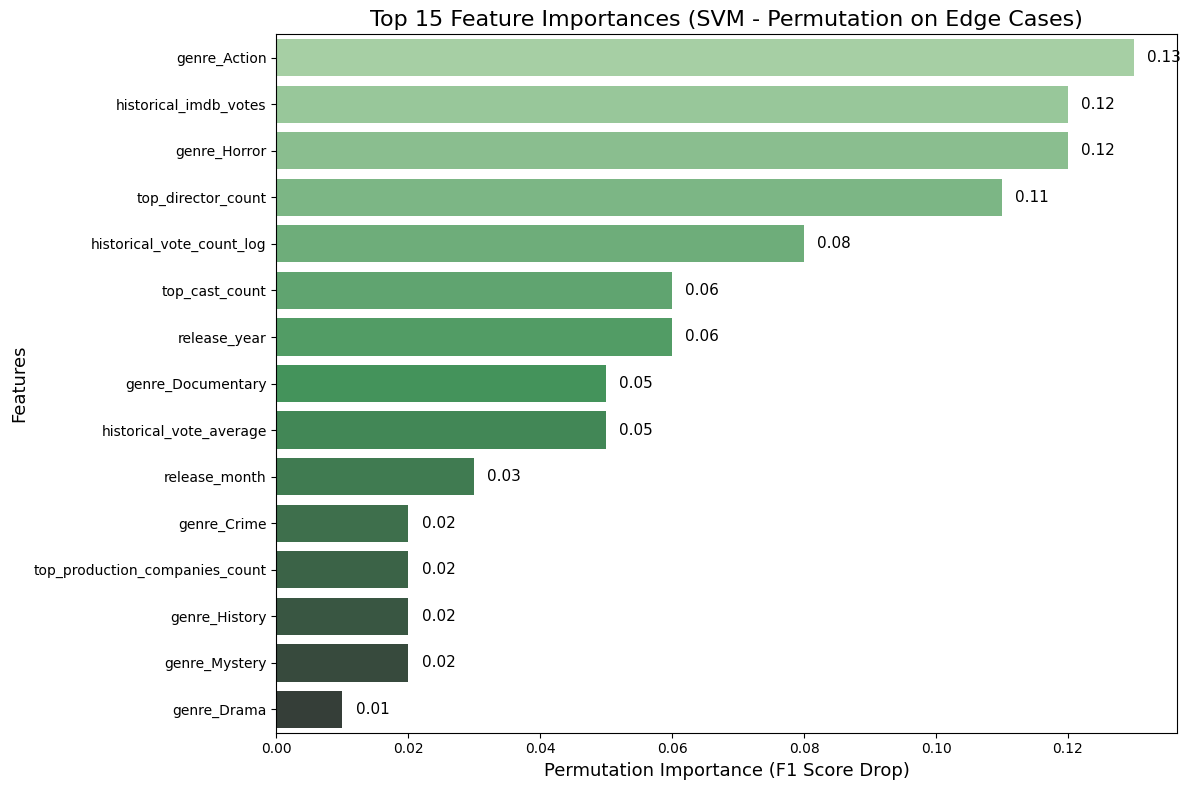

In [ ]:
from sklearn.inspection import permutation_importance
# Use the original column names from unscaled DataFrame
feature_names = X_test_edge.columns  # This should be a DataFrame

# Compute permutation importance
perm_result = permutation_importance(
    best_svm,
    X_test_edge_scaled,
    y_test_edge,
    n_repeats=30,
    random_state=42,
    scoring='f1'
)

# Format result
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_result.importances_mean.round(2)
}).sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=perm_df, x='Importance', y='Feature', palette='Greens_d')

# Add value labels
for i, (val, feature) in enumerate(zip(perm_df['Importance'], perm_df['Feature'])):
    plt.text(val + 0.002, i, f"{val:.2f}", va='center', fontsize=11)

plt.title("Top 15 Feature Importances (SVM - Permutation on Edge Cases)", fontsize=16)
plt.xlabel("Permutation Importance (F1 Score Drop)", fontsize=13)
plt.ylabel("Features", fontsize=13)
plt.tight_layout()
plt.show()

### SVM Feature Importance on Edge Cases (SHAP)

  0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-47-8187d0c4b569>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=shap_importance_df, x='SHAP Value', y='Feature', palette='Oranges_d')


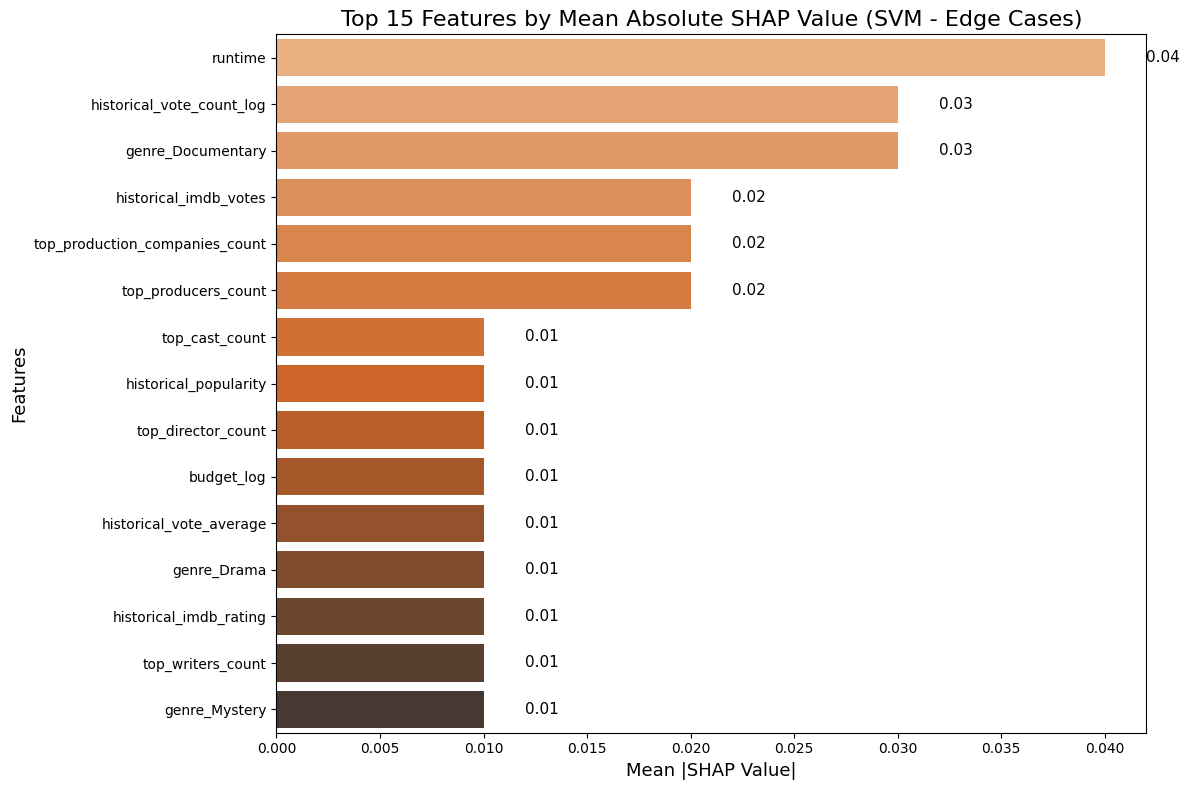

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare background (100 training rows)
background = X_train_scaled[:100]

# Step 2: SHAP KernelExplainer for black-box SVM
explainer_svm = shap.KernelExplainer(best_svm.predict_proba, background)

# Step 3: Compute SHAP values for edge test set
# Output will be shape: (n_samples, n_features, n_classes)
shap_values_svm = explainer_svm.shap_values(X_test_edge_scaled)

# Step 4: Select class 1 SHAP values
shap_class1 = shap_values_svm[:, :, 1]  # shape (12, 35)

# Step 5: Convert to DataFrame using column names
feature_names = X_test_edge.columns
shap_df = pd.DataFrame(shap_class1, columns=feature_names)

# Step 6: Compute mean absolute SHAP values
mean_shap = shap_df.abs().mean().sort_values(ascending=False).head(15).round(2)
shap_importance_df = pd.DataFrame({
    'Feature': mean_shap.index,
    'SHAP Value': mean_shap.values
})

# Step 7: Plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=shap_importance_df, x='SHAP Value', y='Feature', palette='Oranges_d')

# Add SHAP value labels
for i, (val, feature) in enumerate(zip(shap_importance_df['SHAP Value'], shap_importance_df['Feature'])):
    plt.text(val + 0.002, i, f"{val:.2f}", va='center', fontsize=11)

plt.title("Top 15 Features by Mean Absolute SHAP Value (SVM - Edge Cases)", fontsize=16)
plt.xlabel("Mean |SHAP Value|", fontsize=13)
plt.ylabel("Features", fontsize=13)
plt.tight_layout()
plt.show()

## MLP

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# MLP GridSearch
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'early_stopping': [True],
    'max_iter': [300]
}

grid_mlp = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)
grid_mlp.fit(X_train_scaled, y_train)
best_mlp = grid_mlp.best_estimator_
print("Best MLP Params:", grid_mlp.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best MLP Params: {'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 300}


In [ ]:
# Step 1: Predict
y_pred_mlp_normal = best_mlp.predict(X_test_normal_scaled)
y_pred_mlp_edge = best_mlp.predict(X_test_edge_scaled)

# Step 2: Probabilities
y_prob_mlp_normal = best_mlp.predict_proba(X_test_normal_scaled)[:, 1]
y_prob_mlp_edge = best_mlp.predict_proba(X_test_edge_scaled)[:, 1]

# Step 3: Store all metrics
mlp_results = {
    'normal': compute_metrics(y_test_normal, y_pred_mlp_normal, y_prob_mlp_normal),
    'edge': compute_metrics(y_test_edge, y_pred_mlp_edge, y_prob_mlp_edge)
}

# Step 4: Print
print("\n📊 MLP - Normal Test Set:")
for metric, value in mlp_results['normal'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")

print("\n📊 MLP - Edge Test Set:")
for metric, value in mlp_results['edge'].items():
    if metric == 'Confusion Matrix':
        print("Confusion Matrix:")
        print(value)
    elif metric in ['FPR', 'TPR']:
        continue
    else:
        print(f"{metric}: {value:.4f}")


📊 MLP - Normal Test Set:
Accuracy: 0.6635
Recall: 0.3819
Precision: 0.5223
F1 Score: 0.4412
Confusion Matrix:
[[607 139]
 [246 152]]
AUC: 0.6545

📊 MLP - Edge Test Set:
Accuracy: 0.5000
Recall: 0.3333
Precision: 0.5000
F1 Score: 0.4000
Confusion Matrix:
[[4 2]
 [4 2]]
AUC: 0.4722


# Evaluation Comparison

In [ ]:
import pandas as pd

# Step 1: Collect model results
all_results = {
    'Logistic Regression': logreg_results,
    'Decision Tree': cart_results,
    'Random Forest': rf_results,
    'XGBoost': xgb_results,
    'SVM': svm_results,
    'MLP': mlp_results
}

normal_rows = []
edge_rows = []

for model_name, result in all_results.items():
    for set_type, container in zip(['normal', 'edge'], [normal_rows, edge_rows]):
        metrics = result[set_type]
        container.append({
            'Model': model_name,
            'Accuracy': metrics['Accuracy'],
            'Recall': metrics['Recall'],
            'Precision': metrics['Precision'],
            'F1 Score': metrics['F1 Score'],
            'AUC': metrics['AUC']
        })

normal_df = pd.DataFrame(normal_rows)
edge_df = pd.DataFrame(edge_rows)

# Step 2: Manually define the preferred model order
normal_order = ['XGBoost', 'Logistic Regression', 'Random Forest', 'MLP', 'SVM', 'Decision Tree']
edge_order = ['SVM', 'Logistic Regression', 'MLP', 'Random Forest', 'XGBoost', 'Decision Tree']

# Step 3: Apply ordering for presentation
normal_df['Rank'] = normal_df['Model'].apply(lambda x: normal_order.index(x))
edge_df['Rank'] = edge_df['Model'].apply(lambda x: edge_order.index(x))

normal_df = normal_df.sort_values(by='Rank').drop(columns='Rank')
edge_df = edge_df.sort_values(by='Rank').drop(columns='Rank')

# Step 4: Display
print("\n📊 Performance on Normal Test Set:")
display(normal_df)

print("\n📊 Performance on Edge Test Setting :")
display(edge_df)


📊 Performance on Normal Test Set:


,Model,Accuracy,Recall,Precision,F1 Score,AUC
3,XGBoost,0.6495,0.5578,0.4966,0.5254,0.6705
0,Logistic Regression,0.5997,0.5503,0.4398,0.4888,0.6458
2,Random Forest,0.6320,0.4698,0.4710,0.4704,0.6459
5,MLP,0.6635,0.3819,0.5223,0.4412,0.6545
4,SVM,0.6617,0.3241,0.5223,0.4000,0.6376
1,Decision Tree,0.5935,0.4447,0.4204,0.4322,0.5588



📊 Performance on Edge Test Set:


,Model,Accuracy,Recall,Precision,F1 Score,AUC
4,SVM,0.5833,0.5000,0.600,0.5455,0.6667
0,Logistic Regression,0.5000,1.0000,0.500,0.6667,0.5000
5,MLP,0.5000,0.3333,0.500,0.4000,0.4722
2,Random Forest,0.3333,0.5000,0.375,0.4286,0.3889
3,XGBoost,0.4167,0.3333,0.400,0.3636,0.3611
1,Decision Tree,0.1667,0.3333,0.250,0.2857,0.1667


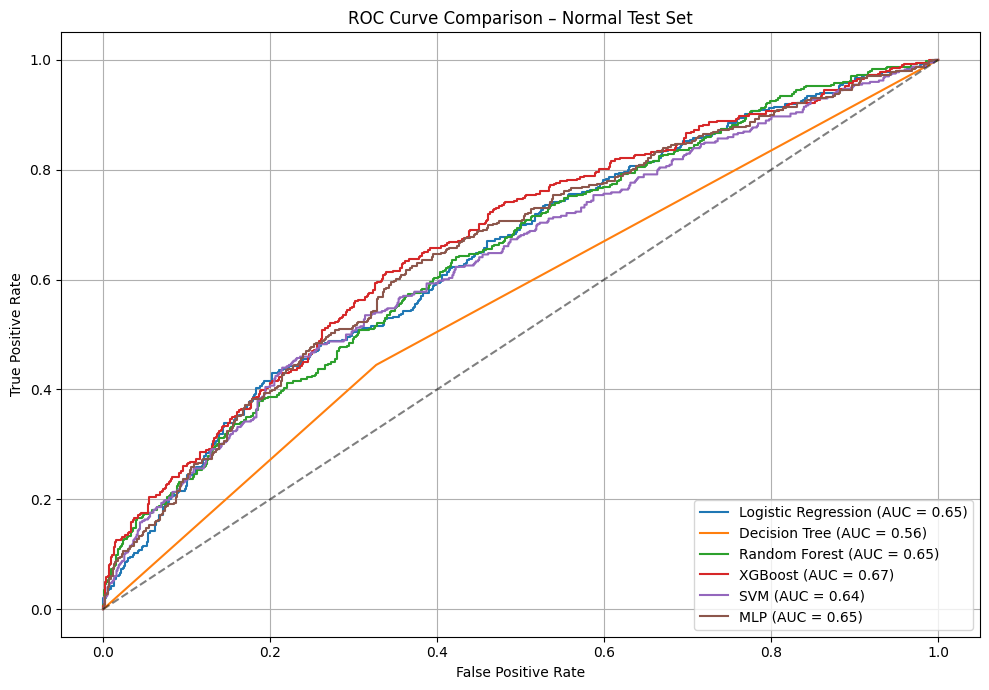

In [ ]:
import matplotlib.pyplot as plt

# ROC dictionary for normal test set
roc_normal = {
    'Logistic Regression': logreg_results['normal'],
    'Decision Tree': cart_results['normal'],
    'Random Forest': rf_results['normal'],
    'XGBoost': xgb_results['normal'],
    'SVM': svm_results['normal'],
    'MLP': mlp_results['normal']
}

# Plot
plt.figure(figsize=(10, 7))
for model_name, roc_data in roc_normal.items():
    plt.plot(roc_data['FPR'], roc_data['TPR'], label=f"{model_name} (AUC = {roc_data['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curve Comparison – Normal Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

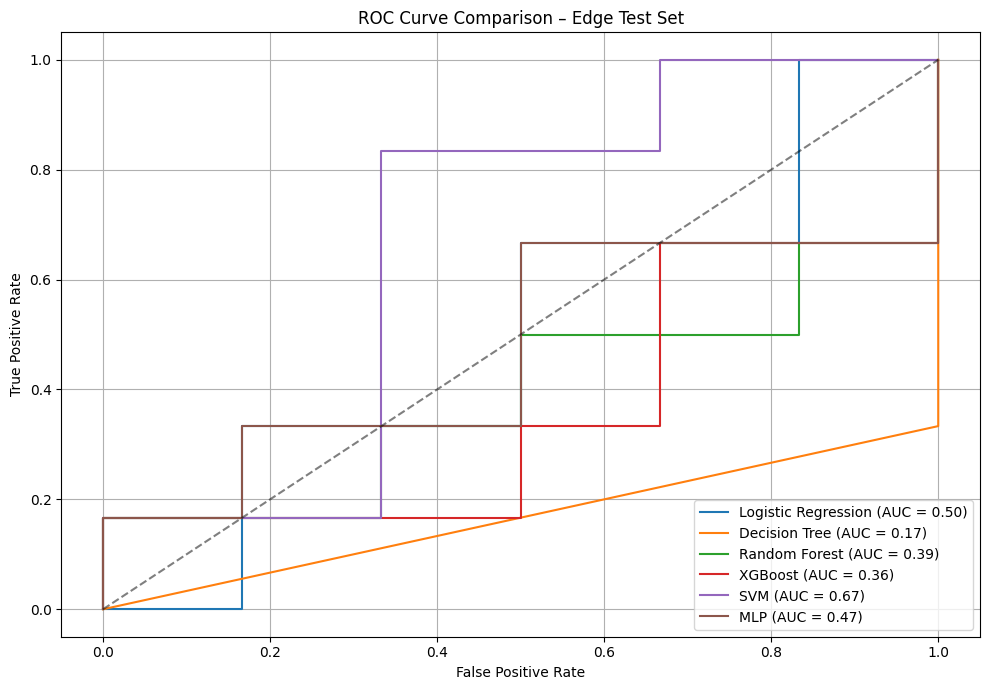

In [ ]:
# ROC dictionary for edge test set
roc_edge = {
    'Logistic Regression': logreg_results['edge'],
    'Decision Tree': cart_results['edge'],
    'Random Forest': rf_results['edge'],
    'XGBoost': xgb_results['edge'],
    'SVM': svm_results['edge'],
    'MLP': mlp_results['edge']
}

# Plot
plt.figure(figsize=(10, 7))
for model_name, roc_data in roc_edge.items():
    plt.plot(roc_data['FPR'], roc_data['TPR'], label=f"{model_name} (AUC = {roc_data['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title("ROC Curve Comparison – Edge Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()